<a href="https://colab.research.google.com/github/ShrishPremkrishna/AI_and_ML/blob/main/ad-mci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
def impute(df, columns, strategy = 'mean'):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer.fit(df.loc[:,columns])
    imputed_cols = imputer.transform(df.loc[:,columns])
    df.loc[:,columns] = imputed_cols

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from matplotlib.ticker import FormatStrFormatter

random_state = 963

In [124]:
# Importing Datasets

gut_raw = pd.read_csv('ADMCGUTMETABOLITESLONG_12_13_21.csv')
lipo_raw = pd.read_csv('ADMCLIPIDOMICSMEIKLELABLONG_08_13_21.csv')
night_raw = pd.read_csv('ADNINIGHTINGALELONG_05_24_21.csv', dtype={"GLN" : str, "PYRUVATE" : str, "CREATININE" : str})

# Converting VISCODE2 to Int64
gut_raw['VISCODE2'] = gut_raw['VISCODE2'].replace('m', '', regex=True)
gut_raw['VISCODE2'] = np.where(gut_raw['VISCODE2'] == 'bl', 0, gut_raw['VISCODE2'])
gut_raw['VISCODE2'] = gut_raw['VISCODE2'].astype(str).astype(int)
gut_raw['RID'] = gut_raw['RID'].astype(str).astype(int)


lipo_raw['VISCODE2'] = lipo_raw['VISCODE2'].replace('m', '', regex=True)
lipo_raw['VISCODE2'] = np.where(lipo_raw['VISCODE2'] == 'bl', 0, lipo_raw['VISCODE2'])
lipo_raw = lipo_raw[lipo_raw['VISCODE2'].notna()]
lipo_raw['VISCODE2'] = lipo_raw['VISCODE2'].astype(str).astype(int)
lipo_raw['RID'] = lipo_raw['RID'].astype(str).astype(int)


night_raw['VISCODE2'] = night_raw['VISCODE2'].replace('m', '', regex=True)
night_raw['VISCODE2'] = np.where(night_raw['VISCODE2'] == 'bl', 0, night_raw['VISCODE2'])
night_raw['VISCODE2'] = night_raw['VISCODE2'].astype(str).astype(int)
night_raw['RID'] = night_raw['RID'].astype(str).astype(int)

# Drop unwanted columns

gut_sliced = gut_raw.drop(columns = ['VISCODE', 'EXAMDATE', 'DRAWDATE', 'SAMPLE_ID', 'VID', 'DRAWTIME', 'update_stamp'])
lipo_sliced = lipo_raw.drop(columns = ['VISCODE', 'EXAMDATE', 'GUSPECID', 'COHORT', 'SAMPLE.ID', 'update_stamp'])
night_sliced = night_raw.drop(columns = ['VISCODE', 'PROT', 'EXAMDATE', 'GUSPECID', 'VID', 'DRAWTIME', 'update_stamp'])

<ipython-input-124-96dbcc8cdb65>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipo_raw['VISCODE2'] = lipo_raw['VISCODE2'].astype(str).astype(int)
<ipython-input-124-96dbcc8cdb65>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipo_raw['RID'] = lipo_raw['RID'].astype(str).astype(int)


In [125]:
# ADMCGUTMETABOLITESLONG_12_13_21 has a few NaN values for UDCA column.
impute(gut_sliced, ['UDCA'])

# ADMCLIPIDOMICSMEIKLELABLONG_08_13_21 has a few NaN values in VISCODE2 column. Replacing it with 'bl'
lipo_sliced['VISCODE2'] = lipo_sliced['VISCODE2'].replace(np.nan, 'bl')

# ADNINIGHTINGALELONG_05_24_21 has non numeric values in columns "PYRUVATE", "GLN", "GLYCEROL", "BOHBUTYRATE", "CREATININE"
# converting them to numeric
night_sliced['PYRUVATE'] = pd.to_numeric(night_sliced['PYRUVATE'], errors='coerce')
night_sliced['GLN'] = pd.to_numeric(night_sliced['GLN'], errors='coerce')
night_sliced['GLYCEROL'] = pd.to_numeric(night_sliced['GLYCEROL'], errors='coerce')
night_sliced['BOHBUTYRATE'] = pd.to_numeric(night_sliced['BOHBUTYRATE'], errors='coerce')
night_sliced['CREATININE'] = pd.to_numeric(night_sliced['CREATININE'], errors='coerce')

# These columbs have NaN values for close to 30% of the rows. Hence dropping them
night_sliced.drop(columns=['XXL_VLDL_C_PCT', 'XXL_VLDL_CE_PCT', 'XXL_VLDL_TG_PCT', 'XXL_VLDL_PL_PCT', 'XXL_VLDL_FC_PCT'])

impute(night_sliced, ~night_sliced.columns.isin(["LOW_GLUCOSE","RID","BELOW_LIMIT_OF_QUANTIFICATION","UNIDENTIFIED_SMALL_MOLECULE_C","UNIDENTIFIED_SMALL_MOLECULE_B", 
"UNIDENTIFIED_SMALL_MOLECULE_A","UNIDENTIFIED_MACROMOLECULES","LOW_PROTEIN","GLUCONOLACTONE","LOW_GLUTAMINE_OR_HIGH_GLUTAMATE", 
"HIGH_PYRUVATE","HIGH_LACTATE","UNEXPECTED_AMINO_ACID_SIGNALS","AMINOCAPROIC_ACID","POLYSACCHARIDES","N_METHYL_2_PYRROLIDONE",  
"ISOPROPYL_ALCOHOL","HIGH_ETHANOL","MEDIUM_ETHANOL","LOW_ETHANOL","CITRATE_PLASMA","EDTA_PLASMA","VISCODE2"]))

In [126]:
# Importing Diagnosis
dx_raw = pd.read_csv('DXSUM_PDXCONV_ADNIALL.csv')

# Create DX Current for ADNI GO & 2
dx_raw['DxChange'] = dx_raw['DXCHANGE']
dx_raw['DxChange'] = np.where(dx_raw['DXCHANGE'] == 4, 2, dx_raw['DxChange'])
dx_raw['DxChange'] = np.where(dx_raw['DXCHANGE'] == 5, 3, dx_raw['DxChange'])
dx_raw['DxChange'] = np.where(dx_raw['DXCHANGE'] == 6, 3, dx_raw['DxChange'])
dx_raw['DxChange'] = np.where(dx_raw['DXCHANGE'] == 7, 1, dx_raw['DxChange'])
dx_raw['DxChange'] = np.where(dx_raw['DXCHANGE'] == 8, 2, dx_raw['DxChange'])
dx_raw['DxChange'] = np.where(dx_raw['DXCHANGE'] == 9, 1, dx_raw['DxChange'])

# Creating diagnosis column
dx_raw['CurrDX'] = dx_raw['DXCURREN']
dx_raw['CurrDX'] = np.where(dx_raw['Phase'] == 'ADNI1', dx_raw['DXCURREN'], dx_raw['CurrDX'])
dx_raw['CurrDX'] = np.where(dx_raw['Phase'] == 'ADNIGO', dx_raw['DxChange'], dx_raw['CurrDX'])
dx_raw['CurrDX'] = np.where(dx_raw['Phase'] == 'ADNI3', dx_raw['DIAGNOSIS'], dx_raw['CurrDX'])
dx_raw['CurrDX'] = np.where(dx_raw['Phase'] == 'ADNI2', dx_raw['DxChange'], dx_raw['CurrDX'])
dx_raw = dx_raw[dx_raw['CurrDX'].notna()]
dx_sliced = dx_raw[['RID', 'VISCODE2', 'CurrDX']]

# Encoding the dependent variable
le = LabelEncoder()
dx_sliced['CurrDX'] = le.fit_transform(dx_sliced['CurrDX'])

# Converting the datatype to Int64 to preserve type during left/outer merge
# Int64 data type can hold NaN values
dx_sliced['CurrDX'] = dx_sliced['CurrDX'].astype('Int64')

# Update VISCODE2 column - bl = 0; and remove m from other VISCODE2 values
dx_sliced['VISCODE2'] = np.where(dx_sliced['VISCODE2'] == 'bl', 0, dx_sliced['VISCODE2'])
dx_sliced['VISCODE2'] = dx_sliced['VISCODE2'].replace('m', '', regex=True)
dx_sliced = dx_sliced[dx_sliced['VISCODE2'] != 'sc']
dx_sliced = dx_sliced[dx_sliced['VISCODE2'] != 'uns1']
dx_sliced = dx_sliced[dx_sliced['VISCODE2'].notna()]
dx_sliced['VISCODE2'] = dx_sliced['VISCODE2'].astype(str).astype(int)
dx_sliced['RID'] = dx_sliced['RID'].astype(str).astype(int)

<ipython-input-126-4bda2db13007>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx_sliced['CurrDX'] = le.fit_transform(dx_sliced['CurrDX'])
<ipython-input-126-4bda2db13007>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx_sliced['CurrDX'] = dx_sliced['CurrDX'].astype('Int64')
<ipython-input-126-4bda2db13007>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [127]:
# Drop Duplicates of 'RID', 'VISCODE2' combination
dx_deduped = dx_sliced.drop_duplicates(subset = ['RID', 'VISCODE2'], keep = 'first').reset_index(drop = True)
gut_deduped = gut_sliced.drop_duplicates(subset = ['RID', 'VISCODE2'], keep = 'first').reset_index(drop = True)
lipo_deduped = lipo_sliced.drop_duplicates(subset = ['RID', 'VISCODE2'], keep = 'first').reset_index(drop = True)
night_deduped = night_sliced.drop_duplicates(subset = ['RID', 'VISCODE2'], keep = 'first').reset_index(drop = True)

# Merge with diagnostic column
gut_dx = pd.merge(gut_deduped, dx_deduped, how='left', left_on = ['RID', 'VISCODE2'], right_on = ['RID', 'VISCODE2'])
lipo_dx = pd.merge(lipo_deduped, dx_deduped, how='left', left_on = ['RID', 'VISCODE2'], right_on = ['RID', 'VISCODE2'])
night_dx = pd.merge(night_deduped, dx_deduped, how='left', left_on = ['RID', 'VISCODE2'], right_on = ['RID', 'VISCODE2'])

# Updating diagnostic labels for missing rows based on before and after trends
gut_dx.at[2203,'CurrDX'] = 2
gut_dx.at[2608,'CurrDX'] = 1
lipo_dx.at[2196,'CurrDX'] = 2
lipo_dx.at[2600,'CurrDX'] = 1
lipo_dx.at[4799,'CurrDX'] = 0
night_dx.at[2203,'CurrDX'] = 2
night_dx.at[2609,'CurrDX'] = 1
night_dx.at[4815,'CurrDX'] = 0

all_dx = pd.merge(
    pd.merge(gut_dx, lipo_dx, how='inner', on=['RID', 'VISCODE2', 'CurrDX']),
    night_dx, how='inner', on=['RID', 'VISCODE2', 'CurrDX'])


In [128]:
all_dx_only = pd.merge(
    pd.merge(gut_dx, lipo_dx[['RID', 'VISCODE2', 'CurrDX']], how='inner', on=['RID', 'VISCODE2', 'CurrDX']),
    night_dx[['RID', 'VISCODE2', 'CurrDX']], how='inner', on=['RID', 'VISCODE2', 'CurrDX'])
    
pivot_all_dx = all_dx_only.pivot(index='RID', columns='VISCODE2', values='CurrDX')


pivot_all_dx[0] = pivot_all_dx[0].astype(str)
pivot_all_dx[6] = pivot_all_dx[6].astype(str)
pivot_all_dx[12] = pivot_all_dx[12].astype(str)
pivot_all_dx[18] = pivot_all_dx[18].astype(str)
pivot_all_dx[24] = pivot_all_dx[24].astype(str)
pivot_all_dx[36] = pivot_all_dx[36].astype(str)
pivot_all_dx[48] = pivot_all_dx[48].astype(str)
pivot_all_dx[60] = pivot_all_dx[60].astype(str)
pivot_all_dx[72] = pivot_all_dx[72].astype(str)
pivot_all_dx[84] = pivot_all_dx[84].astype(str)
pivot_all_dx[96] = pivot_all_dx[96].astype(str)
pivot_all_dx[108] = pivot_all_dx[108].astype(str)
pivot_all_dx[120] = pivot_all_dx[120].astype(str)

# Replace column value
pivot_all_dx=pivot_all_dx.replace('<NA>','')

pivot_all_dx['dx_all'] = pivot_all_dx[0].str.cat(pivot_all_dx[6], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[12], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[18], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[24], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[36], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[48], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[60], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[72], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[84], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[96], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[108], sep='-')
pivot_all_dx['dx_all'] = pivot_all_dx['dx_all'].str.cat(pivot_all_dx[120], sep='-')
# print (pivot_all_dx.head())
pivot_all_dx = pivot_all_dx.reset_index()
# print (pivot_all_dx_index.head())

# converts = pivot_all_dx[(pivot_all_dx['dx_all'].str.contains('0')) & ((pivot_all_dx['dx_all'].str.contains('1')) | (pivot_all_dx['dx_all'].str.contains('2')))]
non_converts = pivot_all_dx[(pivot_all_dx['dx_all'].str.contains('0'))]
non_converts = non_converts[~non_converts["dx_all"].str.contains('1')]
non_converts = non_converts[~non_converts["dx_all"].str.contains('2')]
mci_converts = pivot_all_dx[(pivot_all_dx['dx_all'].str.contains('1'))]
mci_converts = mci_converts[~mci_converts["dx_all"].str.contains('2')]

# print(mci_converts)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

mci_dx = all_dx[(all_dx['RID'].isin(mci_converts["RID"]))]
# print(mci_dx[mci_dx["RID"] == 94])
mci_dx.drop(['CurrDX'], axis=1, inplace=True)
mci_dx["CONVERT"] = 1
# print(mci_dx.shape)

nc_dx = all_dx[(all_dx['RID'].isin(non_converts["RID"]))]
# print(nc_dx[nc_dx["RID"] == 94])
nc_dx.drop(['CurrDX'], axis=1, inplace=True)
nc_dx["CONVERT"] = 0
# print(nc_dx.shape)


convert = pd.concat([mci_dx, nc_dx])
# all = convert.drop(columns = ['RID', 'VISCODE2'], inplace=True)
# all = convert.copy()
# print(convert.shape)

# convert.head(10)

/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-128-3b79f864d670>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mci_dx["CONVERT"] = 1
<ipython-input-128-3b79f864d670>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nc_d

In [305]:

df_X = convert.loc[:, ~convert.columns.isin(['CONVERT'])].astype('int')
df_y = convert['CONVERT'].astype('int')
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size = 0.2, random_state = random_state)

df_scaler = StandardScaler()
all_X_train = df_X_train.copy()
all_X_train.iloc[:,:] = df_scaler.fit_transform(all_X_train.iloc[:,:])
all_X_test = df_X_test.copy()
all_X_test.iloc[:,:] = df_scaler.transform(all_X_test.iloc[:,:])
all_y_train = df_y_train.copy()
all_y_test = df_y_test.copy()
# return df_X_train_scaled, df_X_test_scaled, df_y_train, df_y_test

# all_X_train, all_X_test, all_y_train, all_y_test = scale_data(df_X_train, df_X_test, df_y_train, df_y_test)

# Generate dummy data
x_train = all_X_train.drop(columns = ['RID', 'VISCODE2'])
x_test = all_X_test.drop(columns = ['RID', 'VISCODE2'])

y_train = to_categorical(all_y_train)
y_test = to_categorical(all_y_test)
# df_X_test.head()


# New Section

In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Build model
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=1156))
model.add(Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(x_train, y_train, validation_split=0.10, epochs=50, batch_size=256)

# Generate dummy validation data


# print(y_test)
# Evaluate model on validation data
score = model.evaluate(x_test, y_test, batch_size=64)
y_pred_raw = model.predict(x_test)
y_pred = np.argmax(y_pred_raw, axis=1)


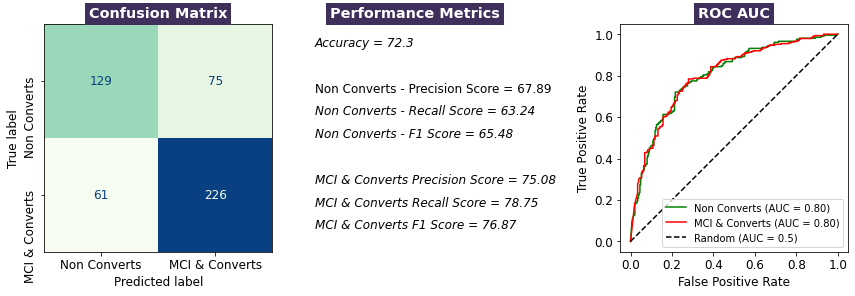

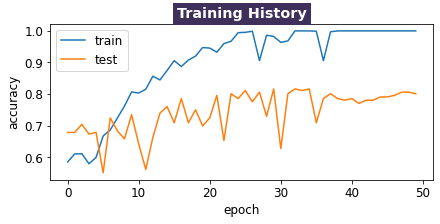

In [181]:
target_names = ['Non Converts', 'MCI & Converts']


conf_matrix = confusion_matrix(all_y_test, y_pred)
accu_score = accuracy_score(all_y_test, y_pred) 
prec_score = precision_score(all_y_test, y_pred, average=None)
reca_score = recall_score(all_y_test, y_pred, average=None)
fone_score = f1_score(all_y_test, y_pred, average=None)

title_bbox={'facecolor': '#3e2f5b', 'edgecolor':'none'}

fig = plt.figure(constrained_layout=True)
plt.rcParams.update({'font.size': 12})
fig.set_size_inches(12, 4)
gs = fig.add_gridspec(1, 12)

ax1 = fig.add_subplot(gs[0, 0:4])
ax1.set_title("Confusion Matrix", bbox=title_bbox, color="white", fontweight='bold')
ConfusionMatrixDisplay(conf_matrix, display_labels = target_names).plot(cmap='GnBu', colorbar=False, ax=ax1)
ax1.set_yticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)

ax3 = fig.add_subplot(gs[0, 4:8])
ax3.set_title('Performance Metrics', bbox=title_bbox, color="white", fontweight='bold')
ax3.axis([0, 10, 0, 10])
ax3.axis('off')
ax3.text(1, 9, 'Accuracy = %s' % round(accu_score * 100, 2), style='italic')
ax3.text(1, 7, 'Non Converts - Precision Score = %s' % round(prec_score[0] * 100, 2))
ax3.text(1, 6, 'Non Converts - Recall Score = %s' % round(reca_score[0] * 100, 2), style='italic')
ax3.text(1, 5, 'Non Converts - F1 Score = %s' % round(fone_score[0] * 100, 2), style='italic')
ax3.text(1, 3, 'MCI & Converts Precision Score = %s' % round(prec_score[1] * 100, 2), style='italic')
ax3.text(1, 2, 'MCI & Converts Recall Score = %s' % round(reca_score[1] * 100, 2), style='italic')
ax3.text(1, 1, 'MCI & Converts F1 Score = %s' % round(fone_score[1] * 100, 2), style='italic')

ax4 = fig.add_subplot(gs[0, 8:12])
colors = cycle(["green", "red"])
for class_id, color in zip(range(2), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_pred_raw[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax4,
    )
ax4.set_title("ROC AUC", bbox=title_bbox, color="white", fontweight='bold')
ax4.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
ax4.axis("square")
ax4.set_xlabel("False Positive Rate")
ax4.set_ylabel("True Positive Rate")
ax4.legend(prop={'size': 10})



# target_names = ['NC', 'MCI', 'AD']
fig2 = plt.figure(constrained_layout=True)
plt.rcParams.update({'font.size': 12})
fig2.set_size_inches(6, 3)
gs = fig2.add_gridspec(1, 1)

ax2 = fig2.add_subplot(gs[0, 0])
ax2.set_title('Training History', bbox=title_bbox, color="white", fontweight='bold')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')


plt.show()



In [376]:
# print(dx_deduped[dx_deduped["RID"] == 374])
# print(dx_deduped[dx_deduped["RID"] == 94])
# print(pivot_all_dx[pivot_all_dx["RID"] == 94])
# print(df_X_test[df_X_test["RID"] == 94])
# pivot_test = pivot_all_dx[(pivot_all_dx['RID'].isin(df_X_test['RID']))]
# print(pivot_test)
# print(pivot_test.shape)
# print(df_X_test.shape)

df_X_test_reset = df_X_test.reset_index()
df_y_test_reset = df_y_test.reset_index()

pivot_all = pivot_all_dx[(pivot_all_dx['RID'].isin(df_X_test_reset['RID']))]
pivot_all = pivot_all.reset_index()
# print(pivot_all.shape)
# print(pivot_all.head())
# print(pivot_all.columns)

df_test = pd.concat([df_X_test_reset, df_y_test_reset], axis=1)
print(df_X_test_reset.shape)
print(df_y_test.shape)
print(df_X_test_reset.shape)
print(df_y_test_reset.shape)
print(df_test.shape)

pivot_test = df_test.pivot(index='RID', columns='VISCODE2', values='CONVERT')
for col in pivot_test:
  pivot_test[col] = pivot_test[col].astype('Int64').astype(str)
pivot_test=pivot_test.replace('<NA>','')
pivot_test = pivot_test.replace('1','CV')
pivot_test = pivot_test.replace('0','NC')
pivot_test = pivot_test.reset_index()
print(pivot_test.shape)

convert_filter = convert[(convert['RID'].isin(df_X_test_reset['RID']))]
# print(convert_reset.head())
pivot_convert = convert_filter.pivot(index='RID', columns='VISCODE2', values='CONVERT')
for col in pivot_convert:
  pivot_convert[col] = pivot_convert[col].astype('Int64').astype(str)
pivot_convert=pivot_convert.replace('<NA>','')
pivot_convert = pivot_convert.replace('1','CV')
pivot_convert = pivot_convert.replace('0','NC')
pivot_convert = pivot_convert.reset_index()
print(pivot_convert.shape)
print(pivot_convert.head())

df_y_pred = pd.DataFrame(y_pred)
df_y_pred.columns = ['CONVERT']
df_predict = pd.concat([df_X_test_reset, df_y_pred], axis=1)
print(df_X_test_reset.shape)
print(df_y_pred.shape)
print(df_predict.shape)

pivot_predict = df_predict.pivot(index='RID', columns='VISCODE2', values='CONVERT')
for col in pivot_predict:
  pivot_predict[col] = pivot_predict[col].astype('Int64').astype(str)
pivot_predict = pivot_predict.replace('<NA>','')
pivot_predict = pivot_predict.replace('1','CV')
pivot_predict = pivot_predict.replace('0','NC')
pivot_predict = pivot_predict.reset_index()
print(pivot_predict.shape)
print(pivot_predict.head())



(491, 1159)
(491,)
(491, 1159)
(491, 2)
(491, 1161)
(387, 13)
(387, 14)
VISCODE2  RID   0 6  12 18  24 36 48 60 72 84 96 108 120
0           4  CV    CV                                 
1           5  NC    NC     NC                          
2           6  CV    CV     CV                          
3          14  NC    NC     NC                          
4          16  NC    NC     NC                          
(491, 1159)
(491, 1)
(491, 1160)
(387, 13)
VISCODE2  RID 0 6  12 18  24 36 48 60 72 84 96 108
0           4      NC                             
1           5      NC                             
2           6             CV                      
3          14             CV                      
4          16      NC     CV                      


In [377]:
pivot_convert[pivot_convert["RID"].isin(np.array(pivot_predict.head(2)["RID"]))]

VISCODE2,RID,0,6,12,18,24,36,48,60,72,84,96,108,120
0,4,CV,,CV,,,,,,,,,,
1,5,NC,,NC,,NC,,,,,,,,


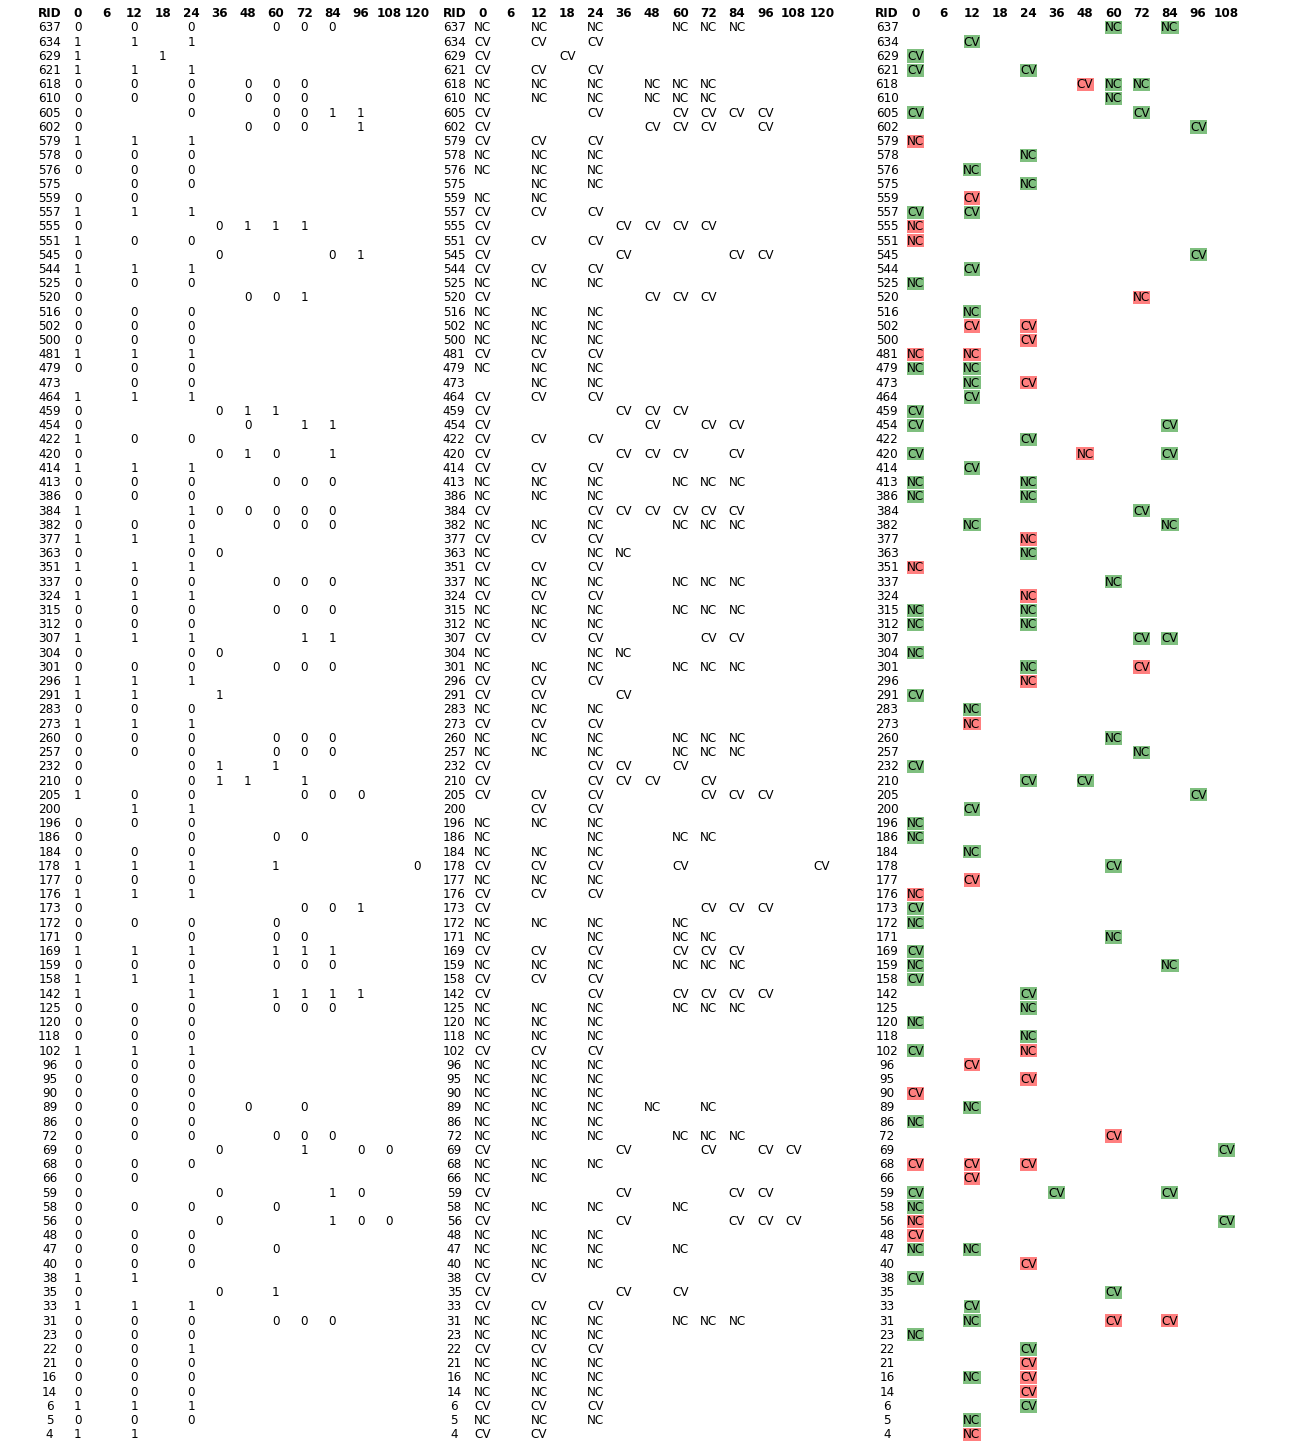

In [393]:
plt_all = pivot_all[pivot_all["RID"].isin(np.array(pivot_predict.head(100)["RID"]))]
plt_convert = pivot_convert[pivot_convert["RID"].isin(np.array(pivot_predict.head(100)["RID"]))]
plt_predict = pivot_predict[pivot_predict["RID"].isin(np.array(pivot_predict.head(100)["RID"]))]

fig = plt.figure(constrained_layout=True)
# plt.rcParams.update({'font.size': 12})
# fig.suptitle(title, fontsize=24)
fig.set_size_inches(18, 20)
gs = fig.add_gridspec(1, 3)

ncols = 15
nrows = plt_all.shape[0]
# print(nrows)

ax1 = fig.add_subplot(gs[0, 0:1])
ax1.set_xlim(0, ncols)
ax1.set_ylim(0, nrows)
ax1.set_axis_off()
for y in range(0, nrows):
  for count, x in enumerate(plt_all):
    if ((x != 'index') & (x != 'dx_all')):
      ax1.annotate(xy=(count + 0.5, y), text=plt_all[x][y], ha='center')
for count, x in enumerate(plt_all):
  if ((x != 'index') & (x != 'dx_all')):
    ax1.annotate(xy=(count + 0.5, nrows), text=x, weight='bold', ha='center')

# ax2 = fig.add_subplot(gs[0, 1:2])
# ax2.set_xlim(0, ncols)
# ax2.set_ylim(0, nrows)
# ax2.set_axis_off()
# for y in range(0, nrows):
#   for count, x in enumerate(pivot_test):
#     if ((x != 'index') & (x != 'dx_all')):
#       ax2.annotate(xy=(count + 0.5, y), text=pivot_test[x][y], ha='center')
# for count, x in enumerate(pivot_test):
#   if ((x != 'index') & (x != 'dx_all')):
#     ax2.annotate(xy=(count + 0.5, nrows), text=x, weight='bold', ha='center')

ax2 = fig.add_subplot(gs[0, 1:2])
ax2.set_xlim(0, ncols)
ax2.set_ylim(0, nrows)
ax2.set_axis_off()
for y in range(0, nrows):
  for count, x in enumerate(plt_convert):
    if ((x != 'index') & (x != 'dx_all')):
      # print(x)
      # print(y)
      ax2.text(x=count+0.5, y=y, s=plt_convert[x][y], ha='center')
for count, x in enumerate(plt_convert):
  if ((x != 'index') & (x != 'dx_all')):
    ax2.text(x=count + 0.5, y=nrows, s=x, weight='bold', ha='center')

ax3 = fig.add_subplot(gs[0, 2:3])
ax3.set_xlim(0, ncols)
ax3.set_ylim(0, nrows)
ax3.set_axis_off()
for y in range(0, nrows):
  for count, x in enumerate(plt_predict):
    if ((x != 'index') & (x != 'dx_all')):
      if ((x != 'RID')):
        fc = 'green' if plt_predict[x][y] == plt_convert[x][y] else 'red'
      else:
        fc = 'white'
      ax3.text(x=count+0.5, y=y, s=plt_predict[x][y], ha='center', bbox=dict(facecolor=fc, alpha=0.5, pad=0.1, edgecolor='none'))
for count, x in enumerate(plt_predict):
  if ((x != 'index') & (x != 'dx_all')):
    ax3.text(x=count + 0.5, y=nrows, s=x, weight='bold', ha='center')